Author: Cezary Januszek

*Created on Saturday, November 11th 2023*
# Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model 
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

# III. Baseline prediction model

In this notebook, we build the baseline flight delay prediction model. As mentioned in the previous steps, our predicted delay is defined only by the arrival delay of the flights.
As we have seen in the EDA step, the departure and arrival delays of flights are highly correlated. This makes the departure delay an impactful feature for the arrival delay prediction. Therefore, two apporaches are adopted here: first we check how the prediction model performs without this feature, second we add the departure delay to our inputs and reevaluate the model.

To solve our flight prediction problem, a **classification model** will allow passengers to predict if their flight would be delayed or not, using one of the 4 prediction classes:
- *No delay* (less than 15min)
- *Delay* (between 15min and 1h)
- *Important Delay* (between 1h and 3h)
- *Big Delay* (more than 3h)

The pipeline to build our baseline classification model is as follows:
1. Data pre-processing for feature cleaning and extraction
2. Train-test split
3. Choosing the model and hyperparameters tuning
4. Performance evaluation



-----------------------------
Glossary of *flights_df* feature columns:
   - *AIRLINE*: IATA CODE for the airline
   - *ORIGIN_AIRPORT and DESTINATION_AIRPORT*: origin and destination airport of the flight
   - *SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL*: scheduled times and date of flight departure and landing
   - *DEPARTURE_TIME and ARRIVAL_TIME*: actual real times of flight takeoff and landing
   - *DATE_OF_WEEK*: day of week of scheduled flight
   - *DEPARTURE_DELAY and ARRIVAL_DELAY*: differences between scheduled and real times of flight departure and arrival
   - *DISTANCE*: travel distance between origin and destination airports (in miles)
   - *SCHEDULED_TIME*: scheduled travel time between origin and destination airports

In [3]:
# Imports
%load_ext autoreload
%autoreload 2

from IPython.core.pylabtools import figsize
figsize(10, 8)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from collections import Counter
from helper_functions import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler

import shap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load data
flights_df = pd.read_pickle(os.path.abspath('./Data/flights.pkl'))
airports_df = pd.read_pickle(os.path.abspath('./Data/airports.pkl'))
airlines_df = pd.read_csv(os.path.abspath('./Data/airlines.csv'))
                          

### Data pre-processing for classification

For the task of classification we need to extract some information from dates and hours to put them in simple numerical values as well as we should encode categorical factors (airline, airport).

In [5]:
# extract day, month from dates and hour, minutes from time
flights_df['DEPARTURE_DAY'] = flights_df['DATE'].apply(lambda x: x.day)
flights_df['DEPARTURE_MONTH'] = flights_df['DATE'].apply(lambda x: x.month)

flights_df['ARRIVAL_DAY'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.day)
flights_df['ARRIVAL_MONTH'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.month)

flights_df['SCHEDULED_DEPARTURE_HOUR'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour)
flights_df['SCHEDULED_DEPARTURE_MIN'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.minute)

flights_df['SCHEDULED_ARRIVAL_HOUR'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour)
flights_df['SCHEDULED_ARRIVAL_MIN'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.minute)

flights_df = flights_df.drop(['DATE', 'ARRIVAL_DATE', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1)

Additionally, some new features are derived from our data:
- mean departure delay for each airline-route pair (a route is defined as a flight trip between an origin airport and destination airport)
- mean taxi-out time at origin airport
- mean taxi-in time at destination airport
- latitude and longitude for origin and destination airports

In [6]:
# Add mean route-airline departure delay
mean_route_delays = flights_df.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'])['DEPARTURE_DELAY'].mean()
mean_route_delays.name = 'MEAN_ROUTE_AIRLINE_DELAY'
flights_df = flights_df.merge(mean_route_delays, left_on=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'], right_index=True)

# Compute the mean taxi-out time for each origin airport and taxi-out time for each destination airport
mean_taxi_out_origin = flights_df.groupby('ORIGIN_AIRPORT')['TAXI_OUT'].mean()
mean_taxi_in_destination = flights_df.groupby('DESTINATION_AIRPORT')['TAXI_IN'].mean()
mean_taxi = pd.DataFrame(mean_taxi_out_origin).join(mean_taxi_in_destination, how='inner')
mean_taxi.columns = ['MEAN_TAXI_OUT_ORIGIN', 'MEAN_TAXI_IN_DESTINATION']

flights_df = flights_df.merge(mean_taxi['MEAN_TAXI_OUT_ORIGIN'], left_on='ORIGIN_AIRPORT', right_index=True)
flights_df = flights_df.merge(mean_taxi['MEAN_TAXI_IN_DESTINATION'], left_on='DESTINATION_AIRPORT', right_index=True)

flights_df = flights_df.drop(['TAXI_IN', 'TAXI_OUT'], axis=1)

# add airports longitude and latitude
origin_latitude = airports_df['LATITUDE']
origin_latitude.name = 'ORIGIN_LATITUDE'
origin_longitude = airports_df['LONGITUDE']
origin_latitude.name = 'ORIGIN_LONGITUDE'

destination_latitude = airports_df['LATITUDE']
destination_latitude.name = 'DESTINATION_LATITUDE'
destination_longitude = airports_df['LONGITUDE']
destination_longitude.name = 'DESTINATION_LONGITUDE'

flights_df = flights_df.merge(origin_latitude, left_on='ORIGIN_AIRPORT', right_index=True)
flights_df = flights_df.merge(origin_longitude, left_on='DESTINATION_AIRPORT', right_index=True)

In [8]:
# we drop DEPARTURE_TIME and ARRIVAL_TIME
flights_df = flights_df.drop(['DEPARTURE_TIME', 'ARRIVAL_TIME'], axis=1)

Finally, to reduce the computation time and memory requirements we limit the data to only the top 20 airports with the most of departure/arrival flights.

In [9]:
# limit the data to only flights between airports in the top 20 with the most flights
top20_airports = flights_df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].count().sort_values(ascending=False).head(20).index
flights_df = flights_df[flights_df['ORIGIN_AIRPORT'].isin(top20_airports)]
flights_df = flights_df[flights_df['DESTINATION_AIRPORT'].isin(top20_airports)].reset_index(drop=True)


### Classification model - baseline

To define if a flight is delayed on arrival a threshold needs to be set. 

The US Federal Aviation Administration considers the flight to be **delayed on arrival when it is 15 min later** than its scheduled time.

For our multi-class classification problem we map the delay times to the 4 classes: No delay, Delay, Important Delay and Big Delay.

In [11]:
data = flights_df.copy()
data['ARRIVAL_DELAY'] = data['ARRIVAL_DELAY'].apply(lambda x: set_delay_class(x))

# save the processed data for classification
#data.to_pickle(os.path.abspath('./Data/flights_data.pkl'))

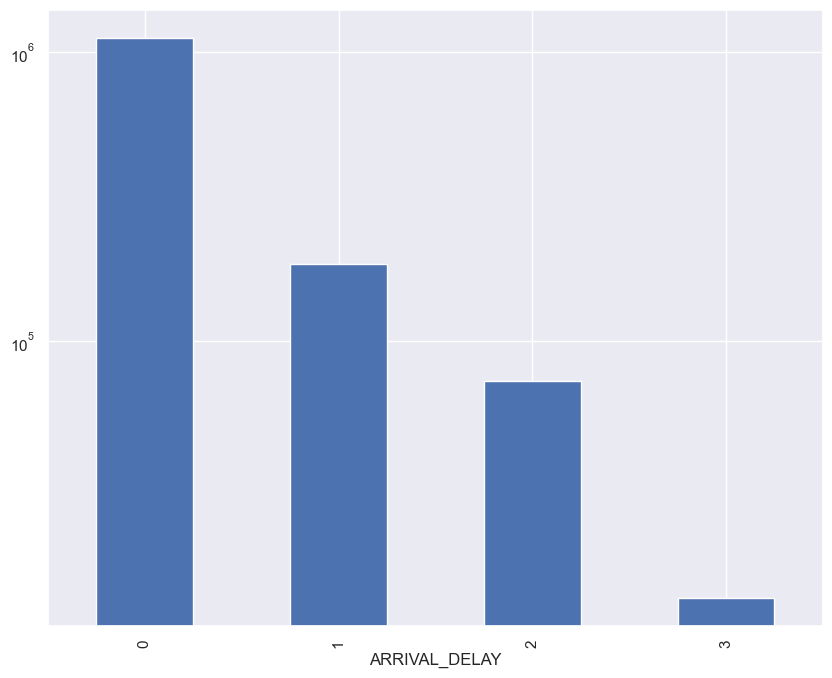

In [12]:
# check class counts
data.groupby('ARRIVAL_DELAY')[data.columns[0]].count().plot.bar()
plt.yscale('log')

As we can see above, with a strong class imbalance we will need to perform some under-sampling of the minority class and rely mostly on precision, recall and F1-score for performance evaluation.

### Without DEPARTURE_DELAY feature

In [27]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY'], axis=1))
Y = data['ARRIVAL_DELAY']

In [28]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

Counter(Y_train)

Train samples:  976964
Test samples:  418700


Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})

In [29]:
# Addressing class imbalance with undersampling the majority class
undersample = RandomUnderSampler(sampling_strategy={0: 400000})
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

Counter(Y_train)

Counter({0: 400000, 1: 128950, 2: 50797, 3: 9011})

In [137]:
# define the model
clf_model = DecisionTreeClassifier(class_weight='balanced')

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 50, 100],
    'min_samples_leaf': [50, 100, 200]
}
# perform 5-fold cross-validation to tune the hyperparameters with grid search
clf_cv = GridSearchCV(clf_model, param_grid=params, cv=3, scoring='neg_log_loss')
clf_cv.fit(X_train, Y_train)

print('Best parameters chosen with CV: ', clf_cv.best_params_)
print('Training loss = {:.3f}'.format(-clf_cv.score(X_train, Y_train)))


Best parameters chosen with CV:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 200}
Training loss = 1.283


Cross-entropy loss = 1.290
Accuracy = 0.349
Precision = 0.287
Recall = 0.349
F1-score = 0.247


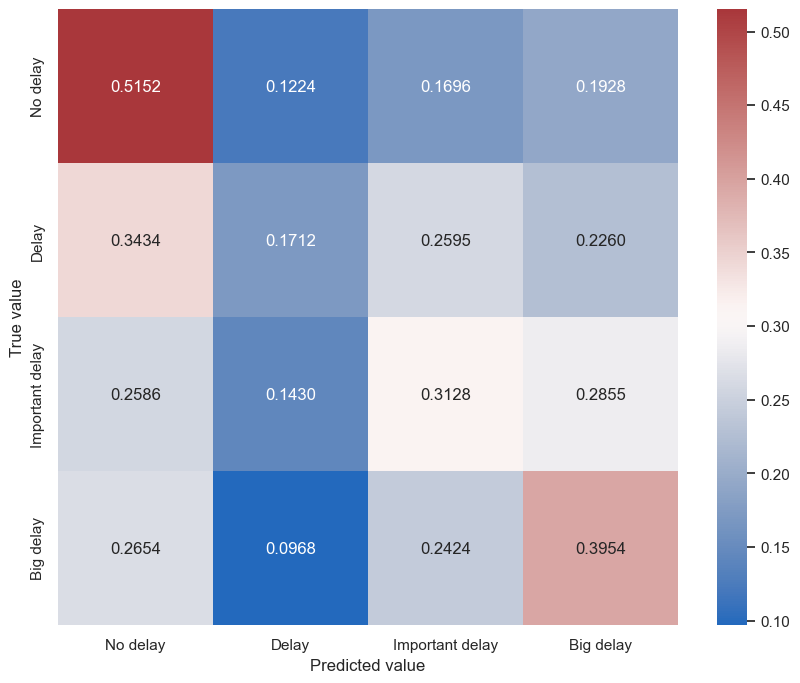

In [31]:
# evaluate metrics
y_pred, y_pred_proba = clf_evaluate_metrics(clf_cv, X_test, Y_test)

### With DEPARTURE_DELAY feature

In [13]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop('ARRIVAL_DELAY', axis=1))
Y = data['ARRIVAL_DELAY']

In [14]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

Counter(Y_train)

Train samples:  976964
Test samples:  418700


Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})

In [15]:
# random under-sampling
undersample = RandomUnderSampler(sampling_strategy={0: 400000})
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

Counter(Y_train)

Counter({0: 400000, 1: 128950, 2: 50797, 3: 9011})

In [16]:
# define the model
clf_model = DecisionTreeClassifier(class_weight='balanced')

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 50, 100],
    'min_samples_leaf': [50, 100, 200]
}
# 5-fold cross-validation with grid search to optimize the choice of hyperparameters
clf_cv = GridSearchCV(clf_model, param_grid=params, cv=3, scoring='neg_log_loss')
clf_cv.fit(X_train, Y_train)

print('Best parameters chosen with CV: ', clf_cv.best_params_)
print('Training loss = {:.3f}'.format(-clf_cv.score(X_train, Y_train)))

Best parameters chosen with CV:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 200}
Training loss = 0.455


Cross-entropy loss = 0.435
Accuracy = 0.821
Precision = 0.757
Recall = 0.821
F1-score = 0.782


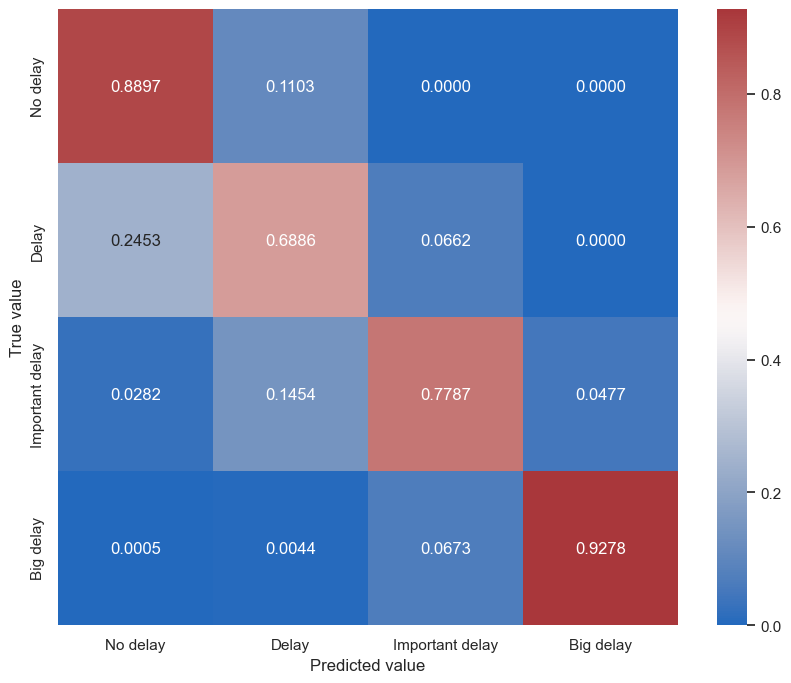

In [24]:
# evaluate metrics
y_pred, y_pred_proba = clf_evaluate_metrics(clf_cv, X_test, Y_test)

## SHAP feature values

In [18]:
# explainer fit
X_test = X_test.replace({False: 0, True: 1})
explainer = shap.Explainer(clf_cv.predict, np.array(X_test))
# get SHAP values
shap_values = explainer(np.array(X_test))

PermutationExplainer explainer: 418701it [3:42:24, 31.37it/s]                                 


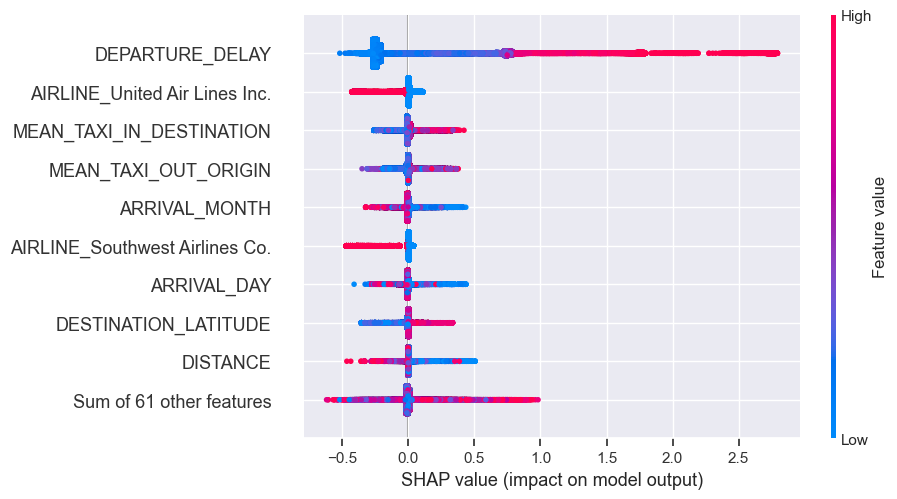

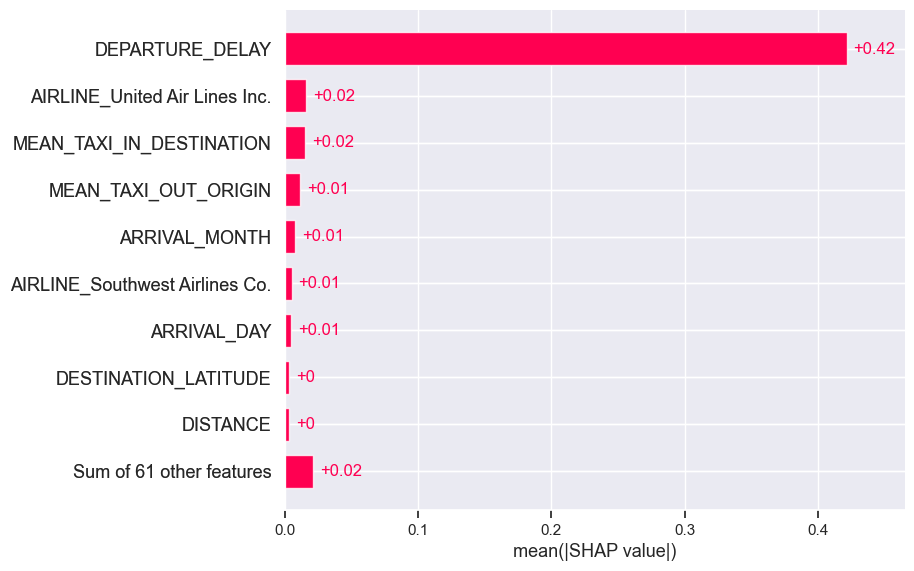

In [22]:
# we make sure that features have their right names
for i, c in enumerate(X.columns):
    shap_values.feature_names[i] = c

# plot
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)